In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

## Objective
We want to retain customers by identifying those who are about to cancel their contract with the company and send them promotional messages,<br>
offering discounts and other benefits, hoping that after receiving the benefits, they will stay with the company. On the other hand we don't want to <br>give promotions to all of our customers.

## Data preparation

In [2]:
df = pd.read_csv('input/data.csv')

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.shape

(7043, 21)

In [5]:
df.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


In [6]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Selecting the right data type 

In [7]:
total_charges = pd.to_numeric(df.TotalCharges, errors='coerce')

In [8]:
total_charges.isnull().sum()

11

In [9]:
df[total_charges.isnull()][['customerID', 'TotalCharges']]

,customerID,TotalCharges
488,4472-LVYGI,
753,3115-CZMZD,
936,5709-LVOEQ,
1082,4367-NUYAO,
1340,1371-DWPAZ,
3331,7644-OMVMY,
3826,3213-VVOLG,
4380,2520-SGTTA,
5218,2923-ARZLG,
6670,4075-WKNIU,


In [10]:
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df.TotalCharges = df.TotalCharges.fillna(0)

In [11]:
df.Churn = (df.Churn == 'Yes').astype('uint8')
df.SeniorCitizen = df.SeniorCitizen.astype('uint8')
df.tenure = df.tenure.astype('uint16') 
df.MonthlyCharges = df.MonthlyCharges.astype('float32')

In [12]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         uint8
Partner              object
Dependents           object
tenure               uint16
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float32
TotalCharges        float64
Churn                 uint8
dtype: object

Normalizing columns names and string columns

In [13]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
string_columns = list(df.dtypes[df.dtypes.values == 'object'].index)

In [14]:
for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

## Setting up the validation framework

In [15]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [16]:
df_train_full.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
1814,5442-pptjy,male,0,yes,yes,12,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.700001,258.35,0
5946,6261-rcvns,female,0,no,no,42,yes,no,dsl,yes,...,yes,yes,no,yes,one_year,no,credit_card_(automatic),73.900002,3160.55,1
3881,2176-osjuv,male,0,yes,no,71,yes,yes,dsl,yes,...,no,yes,no,no,two_year,no,bank_transfer_(automatic),65.150002,4681.75,0
2389,6161-erdgd,male,0,yes,yes,71,yes,yes,dsl,yes,...,yes,yes,yes,yes,one_year,no,electronic_check,85.449997,6300.85,0
3676,2364-ufrom,male,0,no,no,30,yes,no,dsl,yes,...,no,yes,yes,no,one_year,no,electronic_check,70.400002,2044.75,0


In [17]:
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=11)

In [18]:
print(len(df_train), len(df_val), len(df_test))

4225 1409 1409


In [19]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_train_full = df_train_full.reset_index(drop=True)

In [20]:
y_train = df_train['churn'].values
y_val = df_val['churn'].values
y_test = df_test['churn'].values

In [21]:
del df_train['churn']
del df_val['churn']
del df_test['churn']

## EDA

In [22]:
df_train_full.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,5442-pptjy,male,0,yes,yes,12,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.700001,258.35,0
1,6261-rcvns,female,0,no,no,42,yes,no,dsl,yes,...,yes,yes,no,yes,one_year,no,credit_card_(automatic),73.900002,3160.55,1
2,2176-osjuv,male,0,yes,no,71,yes,yes,dsl,yes,...,no,yes,no,no,two_year,no,bank_transfer_(automatic),65.150002,4681.75,0
3,6161-erdgd,male,0,yes,yes,71,yes,yes,dsl,yes,...,yes,yes,yes,yes,one_year,no,electronic_check,85.449997,6300.85,0
4,2364-ufrom,male,0,no,no,30,yes,no,dsl,yes,...,no,yes,yes,no,one_year,no,electronic_check,70.400002,2044.75,0


In [23]:
df_train_full.isnull().sum()

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [24]:
df_train_full.churn.value_counts()

0    4113
1    1521
Name: churn, dtype: int64

In [25]:
global_mean = round(df_train_full.churn.mean() * 100,1)

In [26]:
print(f'Churn rate: {global_mean}%')

Churn rate: 27.0%


The churn rate is 27%, which is a strong indicator of an imbalanced dataset

* Looking at categorical and numerical variables

In [27]:
df_train_full.dtypes

customerid           object
gender               object
seniorcitizen         uint8
partner              object
dependents           object
tenure               uint16
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float32
totalcharges        float64
churn                 uint8
dtype: object

In [28]:
columns_objects_train_full = list(df_train_full.dtypes[df_train_full.dtypes.values == 'object'].index)

In [29]:
for col in columns_objects_train_full:
    print(f'Memory usage of {col} -> {df_train_full[col].memory_usage(deep=True)} \n')

Memory usage of customerid -> 377606 

Memory usage of gender -> 349394 

Memory usage of partner -> 335236 

Memory usage of dependents -> 334200 

Memory usage of phoneservice -> 337621 

Memory usage of multiplelines -> 342579 

Memory usage of internetservice -> 356779 

Memory usage of onlinesecurity -> 354903 

Memory usage of onlinebackup -> 355206 

Memory usage of deviceprotection -> 355231 

Memory usage of techsupport -> 354923 

Memory usage of streamingtv -> 355458 

Memory usage of streamingmovies -> 355491 

Memory usage of contract -> 384962 

Memory usage of paperlessbilling -> 335855 

Memory usage of paymentmethod -> 425680 



In [30]:
for col in columns_objects_train_full[1:]:
    df_train_full[col] = df_train_full[col].astype('category')

In [31]:
for col in columns_objects_train_full:
    print(f'Memory usage of {col} -> {df_train_full[col].memory_usage(deep=True)} \n')

Memory usage of customerid -> 377606 

Memory usage of gender -> 5994 

Memory usage of partner -> 5989 

Memory usage of dependents -> 5989 

Memory usage of phoneservice -> 5989 

Memory usage of multiplelines -> 6062 

Memory usage of internetservice -> 6057 

Memory usage of onlinesecurity -> 6065 

Memory usage of onlinebackup -> 6065 

Memory usage of deviceprotection -> 6065 

Memory usage of techsupport -> 6065 

Memory usage of streamingtv -> 6065 

Memory usage of streamingmovies -> 6065 

Memory usage of contract -> 6071 

Memory usage of paperlessbilling -> 5989 

Memory usage of paymentmethod -> 6238 



In [32]:
columns_objects_train_full

['customerid',
 'gender',
 'partner',
 'dependents',
 'phoneservice',
 'multiplelines',
 'internetservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'contract',
 'paperlessbilling',
 'paymentmethod']

In [33]:
[x for x in df_train_full.columns if x not in columns_objects_train_full]

['seniorcitizen', 'tenure', 'monthlycharges', 'totalcharges', 'churn']

In [34]:
categorical = ['gender',
             'seniorcitizen',
             'partner',
             'dependents',
             'phoneservice',
             'multiplelines',
             'internetservice',
             'onlinesecurity',
             'onlinebackup',
             'deviceprotection',
             'techsupport',
             'streamingtv',
             'streamingmovies',
             'contract',
             'paperlessbilling',
             'paymentmethod']


In [35]:
numerical = [ 'tenure', 'monthlycharges', 'totalcharges']

How mnay unique values each variable has

In [36]:
df_train_full[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

## Feature importance: Churn rate and risk ratio
* Feature importance analysis (part of EDA) - Identifying which features affect our target variable
* Understanding which features may be important for our model

Categorical variables

In [37]:
female_mean = round(df_train_full[df_train_full['gender'] == 'female'].churn.mean()*100,1)
male_mean = round(df_train_full[df_train_full['gender'] == 'male'].churn.mean()*100,1)

In [38]:
print(f'global mean: {global_mean} \nfemale mean: {female_mean} \nmale mean: {male_mean}')

global mean: 27.0 
female mean: 27.7 
male mean: 26.3


The difference between the group rates for both females and males is quite small, which indicates that knowing the gender of the customer does not help us to identify whether they will churn.

In [39]:
churn_partner_yes = round(df_train_full[df_train_full['partner'] == 'yes'].churn.mean()*100,1)
churn_partner_no = round(df_train_full[df_train_full['partner'] == 'no'].churn.mean()*100,1)

In [40]:
print(f'global mean: {global_mean} \npartner yes: {churn_partner_yes} \npartner no: {churn_partner_no}')

global mean: 27.0 
partner yes: 20.5 
partner no: 33.0


Clients with no partner are more likely to churn, which indicates that the partner variable is useful for predicting churn

* Risk ratio: Ratio between two probabilities in different groups  

In [41]:
risk_female = female_mean / global_mean
print(f'Risk ratio for gender = female: {risk_female:.2f}')

Risk ratio for gender = female: 1.03


The risk ratio is a number between zero and infinity, and tells you how likely the element of the group (female) are to have the effect (churn) compared with the entire population

In [42]:
global_mean = df_train_full.churn.mean()
df_group = df_train_full.groupby('gender').churn.agg(['mean'])
df_group['diff'] = df_group['mean'] - global_mean
df_group['risk'] = df_group['mean'] / global_mean
df_group = df_group.reset_index()

In [43]:
df_group.head()

,gender,mean,diff,risk
0,female,0.276824,0.006856,1.025396
1,male,0.263214,-0.006755,0.974980


In [44]:
from IPython.display import display

for col in categorical:
    df_group = df_train_full.groupby(col).churn.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_mean
    df_group['risk'] = df_group['mean'] / global_mean
    df_group = df_group.reset_index()
    display(df_group)


,gender,mean,count,diff,risk
0,female,0.276824,2796,0.006856,1.025396
1,male,0.263214,2838,-0.006755,0.974980


,seniorcitizen,mean,count,diff,risk
0,0,0.242270,4722,-0.027698,0.897403
1,1,0.413377,912,0.143409,1.531208


,partner,mean,count,diff,risk
0,no,0.329809,2932,0.059841,1.221659
1,yes,0.205033,2702,-0.064935,0.759472


,dependents,mean,count,diff,risk
0,no,0.313760,3968,0.043792,1.162212
1,yes,0.165666,1666,-0.104302,0.613651


,phoneservice,mean,count,diff,risk
0,no,0.241316,547,-0.028652,0.893870
1,yes,0.273049,5087,0.003081,1.011412


,multiplelines,mean,count,diff,risk
0,no,0.257407,2700,-0.012561,0.953474
1,no_phone_service,0.241316,547,-0.028652,0.893870
2,yes,0.290742,2387,0.020773,1.076948


,internetservice,mean,count,diff,risk
0,dsl,0.192347,1934,-0.077621,0.712482
1,fiber_optic,0.425171,2479,0.155203,1.574895
2,no,0.077805,1221,-0.192163,0.288201


,onlinesecurity,mean,count,diff,risk
0,no,0.420921,2801,0.150953,1.559152
1,no_internet_service,0.077805,1221,-0.192163,0.288201
2,yes,0.153226,1612,-0.116742,0.567570


,onlinebackup,mean,count,diff,risk
0,no,0.404323,2498,0.134355,1.497672
1,no_internet_service,0.077805,1221,-0.192163,0.288201
2,yes,0.217232,1915,-0.052736,0.804660


,deviceprotection,mean,count,diff,risk
0,no,0.395875,2473,0.125907,1.466379
1,no_internet_service,0.077805,1221,-0.192163,0.288201
2,yes,0.230412,1940,-0.039556,0.853480


,techsupport,mean,count,diff,risk
0,no,0.418914,2781,0.148946,1.551717
1,no_internet_service,0.077805,1221,-0.192163,0.288201
2,yes,0.159926,1632,-0.110042,0.592390


,streamingtv,mean,count,diff,risk
0,no,0.342832,2246,0.072864,1.269897
1,no_internet_service,0.077805,1221,-0.192163,0.288201
2,yes,0.302723,2167,0.032755,1.121328


,streamingmovies,mean,count,diff,risk
0,no,0.338906,2213,0.068938,1.255358
1,no_internet_service,0.077805,1221,-0.192163,0.288201
2,yes,0.307273,2200,0.037305,1.138182


,contract,mean,count,diff,risk
0,month-to-month,0.431701,3104,0.161733,1.599082
1,one_year,0.120573,1186,-0.149395,0.446621
2,two_year,0.028274,1344,-0.241694,0.104730


,paperlessbilling,mean,count,diff,risk
0,no,0.172071,2313,-0.097897,0.637375
1,yes,0.338151,3321,0.068183,1.252560


,paymentmethod,mean,count,diff,risk
0,bank_transfer_(automatic),0.168171,1219,-0.101797,0.622928
1,credit_card_(automatic),0.164339,1217,-0.105630,0.608733
2,electronic_check,0.455890,1893,0.185922,1.688682
3,mailed_check,0.193870,1305,-0.076098,0.718121


Just by looking at the differences and the risks, we can identify the most discriminative features: the featurs that are helpful for detecting churn

## Feature importance: Mutual informmation
*  Mutual information: Tell us how much we can learn about one variable if we know the value of another
* Categorical variables

In [45]:
def calculate_mi(series):
    return mutual_info_score(series, df_train_full.churn)

In [46]:
df_mi = df_train_full[categorical].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')

In [47]:
df_mi

,MI
contract,0.098320
onlinesecurity,0.063085
techsupport,0.061032
internetservice,0.055868
onlinebackup,0.046923
deviceprotection,0.043453
paymentmethod,0.043210
streamingtv,0.031853
streamingmovies,0.031581
paperlessbilling,0.017589


## Feature importance: Correlation
* Correlation coefficient (value from -1 to 1)
* We can measure the dependency between a binary target variable and a numerical variable

In [48]:
df_train_full[numerical].corr()

,tenure,monthlycharges,totalcharges
tenure,1.000000,0.251072,0.828268
monthlycharges,0.251072,1.000000,0.650913
totalcharges,0.828268,0.650913,1.000000


In [49]:
df_train_full[numerical].corrwith(df_train_full.churn).to_frame(name='correlation')

,correlation
tenure,-0.351885
monthlycharges,0.196805
totalcharges,-0.196353


In [50]:
df_train_full[df_train_full['tenure'] <= 2].churn.mean()

0.5953420669577875

In [51]:
df_train_full[(df_train_full['tenure'] > 2) & (df_train_full['tenure'] <= 12)].churn.mean()

0.3994413407821229

In [52]:
df_train_full[df_train_full['tenure'] > 12].churn.mean()

0.17634908339788277

In [53]:
d = {'tenure': ['0-2', '3-12', '>12' ],
     'churn_rate' : [60, 40, 18]
    }

In [54]:
df_tenure_churn = pd.DataFrame(d)

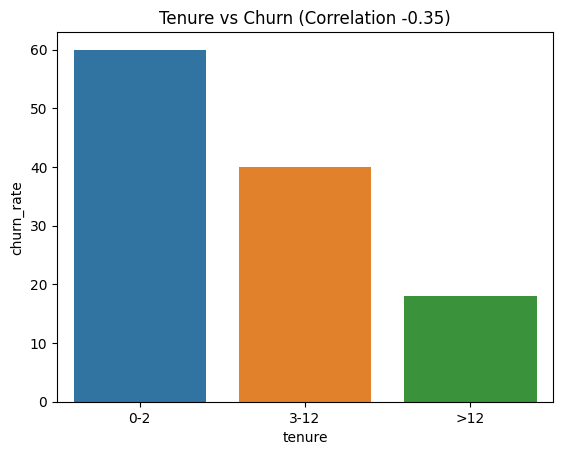

In [55]:
sns.barplot(x=df_tenure_churn.tenure, y=df_tenure_churn.churn_rate)
plt.title('Tenure vs Churn (Correlation -0.35)')
plt.show()

## Feature engineering - One-hot encoding for categorical variables

Converting our fataframe to a list of dictionaries

In [56]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')

In [57]:
train_dict[0]

{'gender': 'female',
 'seniorcitizen': 0,
 'partner': 'yes',
 'dependents': 'yes',
 'phoneservice': 'yes',
 'multiplelines': 'yes',
 'internetservice': 'fiber_optic',
 'onlinesecurity': 'no',
 'onlinebackup': 'yes',
 'deviceprotection': 'yes',
 'techsupport': 'no',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'one_year',
 'paperlessbilling': 'yes',
 'paymentmethod': 'credit_card_(automatic)',
 'tenure': 58,
 'monthlycharges': 105.19999694824219,
 'totalcharges': 6225.4}

In [58]:
dv = DictVectorizer(sparse=False)

In [59]:
X_train = dv.fit_transform(train_dict)

In [60]:
X_train[0]

array([0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 1.05199997e+02, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.80000000e+01,
       6.22540000e+03])

In [61]:
dv.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'dependents=no', 'dependents=yes',
       'deviceprotection=no', 'deviceprotection=no_internet_service',
       'deviceprotection=yes', 'gender=female', 'gender=male',
       'internetservice=dsl', 'internetservice=fiber_optic',
       'internetservice=no', 'monthlycharges', 'multiplelines=no',
       'multiplelines=no_phone_service', 'multiplelines=yes',
       'onlinebackup=no', 'onlinebackup=no_internet_service',
       'onlinebackup=yes', 'onlinesecurity=no',
       'onlinesecurity=no_internet_service', 'onlinesecurity=yes',
       'paperlessbilling=no', 'paperlessbilling=yes', 'partner=no',
       'partner=yes', 'paymentmethod=bank_transfer_(automatic)',
       'paymentmethod=credit_card_(automatic)',
       'paymentmethod=electronic_check', 'paymentmethod=mailed_check',
       'phoneservice=no', 'phoneservice=yes', 'seniorcitizen',
       'streamingmovies=no', 'streamingmovies=no_internet_service',

In [62]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')

In [63]:
X_val = dv.transform(val_dict)

## Logistic regression
* Binary classification
* Sigmoid converts score into a probability, and is always between 0 and 1

In [64]:
def sigmoid(x):
    return 1 / (1+np.exp(-x))

In [65]:
x = np.linspace(-7, 7, 51)

In [66]:
sigmoid(x)

array([9.11051194e-04, 1.20508423e-03, 1.59386223e-03, 2.10780106e-03,
       2.78699622e-03, 3.68423990e-03, 4.86893124e-03, 6.43210847e-03,
       8.49286285e-03, 1.12064063e-02, 1.47740317e-02, 1.94550846e-02,
       2.55807883e-02, 3.35692233e-02, 4.39398154e-02, 5.73241759e-02,
       7.44679452e-02, 9.62155417e-02, 1.23467048e-01, 1.57095469e-01,
       1.97816111e-01, 2.46011284e-01, 3.01534784e-01, 3.63547460e-01,
       4.30453776e-01, 5.00000000e-01, 5.69546224e-01, 6.36452540e-01,
       6.98465216e-01, 7.53988716e-01, 8.02183889e-01, 8.42904531e-01,
       8.76532952e-01, 9.03784458e-01, 9.25532055e-01, 9.42675824e-01,
       9.56060185e-01, 9.66430777e-01, 9.74419212e-01, 9.80544915e-01,
       9.85225968e-01, 9.88793594e-01, 9.91507137e-01, 9.93567892e-01,
       9.95131069e-01, 9.96315760e-01, 9.97213004e-01, 9.97892199e-01,
       9.98406138e-01, 9.98794916e-01, 9.99088949e-01])

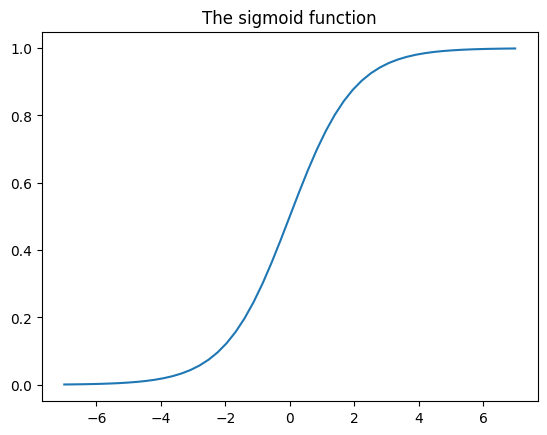

In [67]:
sns.lineplot(x=x,y=sigmoid(x))
plt.title('The sigmoid function')
plt.show()

In [68]:
def linear_regression(xi):
    result = bias
    for j in range(n):
        result = result + xi[j] * w[j]
    return result

In [69]:
def logistic_regression(xi):
    score = bias
    for j in range(n):
        score = score + xi[j] * w[j]
    prob = sigmoid(score)
    return prob

## Training logistic regression


In [70]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [71]:
# Bias term
model.intercept_[0]

-0.13093789439371875

In [72]:
# Weights of the model
dict(zip(dv.get_feature_names_out(), model.coef_[0].round(3)))

{'contract=month-to-month': 0.573,
 'contract=one_year': -0.166,
 'contract=two_year': -0.538,
 'dependents=no': -0.016,
 'dependents=yes': -0.114,
 'deviceprotection=no': 0.076,
 'deviceprotection=no_internet_service': -0.114,
 'deviceprotection=yes': -0.093,
 'gender=female': -0.026,
 'gender=male': -0.105,
 'internetservice=dsl': -0.353,
 'internetservice=fiber_optic': 0.336,
 'internetservice=no': -0.114,
 'monthlycharges': 0.001,
 'multiplelines=no': -0.171,
 'multiplelines=no_phone_service': 0.112,
 'multiplelines=yes': -0.072,
 'onlinebackup=no': 0.12,
 'onlinebackup=no_internet_service': -0.114,
 'onlinebackup=yes': -0.137,
 'onlinesecurity=no': 0.263,
 'onlinesecurity=no_internet_service': -0.114,
 'onlinesecurity=yes': -0.28,
 'paperlessbilling=no': -0.207,
 'paperlessbilling=yes': 0.076,
 'partner=no': -0.107,
 'partner=yes': -0.024,
 'paymentmethod=bank_transfer_(automatic)': -0.056,
 'paymentmethod=credit_card_(automatic)': -0.116,
 'paymentmethod=electronic_check': 0.208,

In [73]:
y_pred = model.predict_proba(X_val)

In [74]:
y_pred

array([[0.7679979 , 0.2320021 ],
       [0.75226287, 0.24773713],
       [0.72286743, 0.27713257],
       ...,
       [0.99773199, 0.00226801],
       [0.87742186, 0.12257814],
       [0.99855878, 0.00144122]])

Selecting the second column of the prediction, the probability that the observation belongs to the positive class (Customer will churn)

In [75]:
y_pred = y_pred[:,1]

In [76]:
y_pred

array([0.2320021 , 0.24773713, 0.27713257, ..., 0.00226801, 0.12257814,
       0.00144122])

* This output (probabilities) is often called *soft* predictions and tell us the probability of churning. It's up to us to decide how to interpret this number and how to use it
* To make actual decisions we need *hard* predictions (bynary values): True (churn, send a promotion) or False(no churn, do not send the promotion) 

Using a 0.5 threshold

In [77]:
churn_decision = y_pred >= 0.5

In [78]:
churn_decision

array([False, False, False, ..., False, False, False])

In [79]:
df_val[churn_decision].head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges
10,6551-gnydg,female,0,yes,yes,14,yes,no,fiber_optic,no,no,no,no,no,yes,month-to-month,yes,bank_transfer_(automatic),80.900002,1152.80
16,0689-nkylf,male,0,no,no,13,yes,no,fiber_optic,no,no,yes,no,yes,no,month-to-month,yes,electronic_check,83.199997,1060.60
18,3398-fshon,female,1,no,no,12,yes,yes,fiber_optic,no,yes,no,no,yes,no,month-to-month,yes,electronic_check,91.300003,1094.50
19,4704-eryfc,female,0,yes,no,22,yes,no,fiber_optic,no,no,no,no,no,no,month-to-month,yes,electronic_check,69.250000,1554.00
26,8258-gstjk,male,1,no,no,3,yes,yes,fiber_optic,no,no,no,no,no,no,month-to-month,yes,electronic_check,77.000000,237.75


### Simple check to measure the quality of our model
* Accuracy: The number of times our predictions match the actual value

In [80]:
accuracy = (y_val == churn_decision).mean()

In [81]:
print(f'The accuracy of our model is {accuracy * 100:.2f} %')

The accuracy of our model is 79.91 %


## Using the model

In [82]:
dict_train_full = df_train_full[categorical + numerical].to_dict(orient='records')

In [83]:
dict_train_full[1:3]

[{'gender': 'female',
  'seniorcitizen': 0,
  'partner': 'no',
  'dependents': 'no',
  'phoneservice': 'yes',
  'multiplelines': 'no',
  'internetservice': 'dsl',
  'onlinesecurity': 'yes',
  'onlinebackup': 'yes',
  'deviceprotection': 'yes',
  'techsupport': 'yes',
  'streamingtv': 'no',
  'streamingmovies': 'yes',
  'contract': 'one_year',
  'paperlessbilling': 'no',
  'paymentmethod': 'credit_card_(automatic)',
  'tenure': 42,
  'monthlycharges': 73.9000015258789,
  'totalcharges': 3160.55},
 {'gender': 'male',
  'seniorcitizen': 0,
  'partner': 'yes',
  'dependents': 'no',
  'phoneservice': 'yes',
  'multiplelines': 'yes',
  'internetservice': 'dsl',
  'onlinesecurity': 'yes',
  'onlinebackup': 'yes',
  'deviceprotection': 'no',
  'techsupport': 'yes',
  'streamingtv': 'no',
  'streamingmovies': 'no',
  'contract': 'two_year',
  'paperlessbilling': 'no',
  'paymentmethod': 'bank_transfer_(automatic)',
  'tenure': 71,
  'monthlycharges': 65.1500015258789,
  'totalcharges': 4681.75}

In [84]:
dv = DictVectorizer(sparse=False)

In [85]:
X_train_full = dv.fit_transform(dict_train_full)

In [86]:
y_train_full = df_train_full.churn.values

In [87]:
dict_test = df_test[categorical + numerical].to_dict(orient='records')
X_test = dv.transform(dict_test)

In [88]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train_full, y_train_full)

LogisticRegression(solver='liblinear')

In [89]:
y_pred = model.predict_proba(X_test)[:,1]

In [90]:
churn_decision = (y_pred >= 0.5)

In [91]:
(churn_decision == y_test).mean()

0.8126330731014905

In [92]:
customer = dict_test[10]
customer

{'gender': 'male',
 'seniorcitizen': 1,
 'partner': 'yes',
 'dependents': 'yes',
 'phoneservice': 'yes',
 'multiplelines': 'no',
 'internetservice': 'fiber_optic',
 'onlinesecurity': 'no',
 'onlinebackup': 'yes',
 'deviceprotection': 'no',
 'techsupport': 'no',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'month-to-month',
 'paperlessbilling': 'yes',
 'paymentmethod': 'mailed_check',
 'tenure': 32,
 'monthlycharges': 93.94999694824219,
 'totalcharges': 2861.45}

In [93]:
X_customer = dv.transform(customer)

In [94]:
X_customer.shape

(1, 45)

In [95]:
model.predict_proba(X_customer)[0,1]

0.4952573576376184

Probability of churn of this customer 0.49, let's check if this customer actually churned or not.

In [96]:
y_test[0]

0

Our model predicted it ok, we do not want to send a promotional email to that customer